In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['image.cmap'] = 'viridis'

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image
from skimage.io import imread
from skimage.util import montage
from tqdm import tqdm
tqdm.pandas() # hack progressbars into pandas
montage_rgb = lambda x, **kwargs: np.stack([montage(x[:, :, :, i], **kwargs) for i in range(x.shape[3])], -1)

In [3]:
!unzip /content/drive/MyDrive/data/images_hur.zip -d /content/images_hur

Streaming output truncated to the last 5000 lines.
  inflating: /content/images_hur/train_another/no_damage/-95.627453_29.859303000000004.jpeg  
  inflating: /content/images_hur/train_another/no_damage/-95.62745600000001_29.777524.jpeg  
  inflating: /content/images_hur/train_another/no_damage/-95.627485_29.777865999999996.jpeg  
  inflating: /content/images_hur/train_another/no_damage/-95.62751800000001_29.857785999999997.jpeg  
  inflating: /content/images_hur/train_another/no_damage/-95.62751999999999_29.860796999999998.jpeg  
  inflating: /content/images_hur/train_another/no_damage/-95.627523_29.770004999999998.jpeg  
  inflating: /content/images_hur/train_another/no_damage/-95.62753000000001_29.863289.jpeg  
  inflating: /content/images_hur/train_another/no_damage/-95.627539_29.827047999999998.jpeg  
  inflating: /content/images_hur/train_another/no_damage/-95.627543_29.860021000000003.jpeg  
  inflating: /content/images_hur/train_another/no_damage/-95.627563_29.8628.jpeg  
  infl

In [4]:
satellite_dir = Path('/content/images_hur')
image_df = pd.DataFrame({'path': list(satellite_dir.glob('**/*.jp*g'))})
image_df.sample(3)

path
18416  /content/images_hur/train_another/no_damage/-9...
15524  /content/images_hur/train_another/damage/-95.6...
12791  /content/images_hur/train_another/damage/-95.2...

In [5]:
image_df['damage'] = image_df['path'].map(lambda x: x.parent.stem)
image_df['data_split'] = image_df['path'].map(lambda x: x.parent.parent.stem)
image_df['location'] = image_df['path'].map(lambda x: x.stem)
image_df['lat'] = image_df['location'].map(lambda x: float(x.split('_')[0]))
image_df['lon'] = image_df['location'].map(lambda x: float(x.split('_')[-1]))
image_df.sample(3)

path  ...        lon
11580  /content/images_hur/train_another/damage/-95.6...  ...  29.964025
3942   /content/images_hur/test_another/damage/-95.61...  ...  29.781163
19558  /content/images_hur/train_another/no_damage/-9...  ...  29.856277

[3 rows x 6 columns]

Text(0.5, 1.0, 'Data by Group')

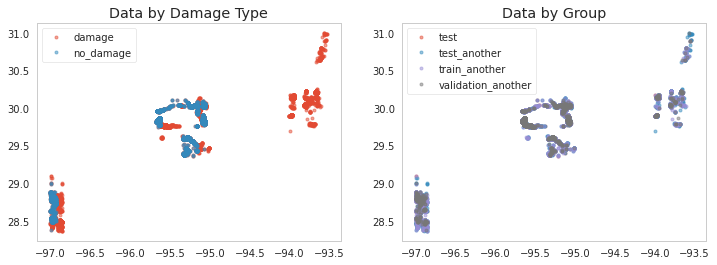

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
for c_group, c_rows in image_df.groupby(['damage']):
    ax1.plot(c_rows['lat'], c_rows['lon'], '.', label=c_group, alpha=0.5)
ax1.legend()
ax1.set_title('Data by Damage Type')
for c_group, c_rows in image_df.groupby(['data_split']):
    ax2.plot(c_rows['lat'], c_rows['lon'], '.', label=c_group, alpha=0.5)
ax2.legend()
ax2.set_title('Data by Group')

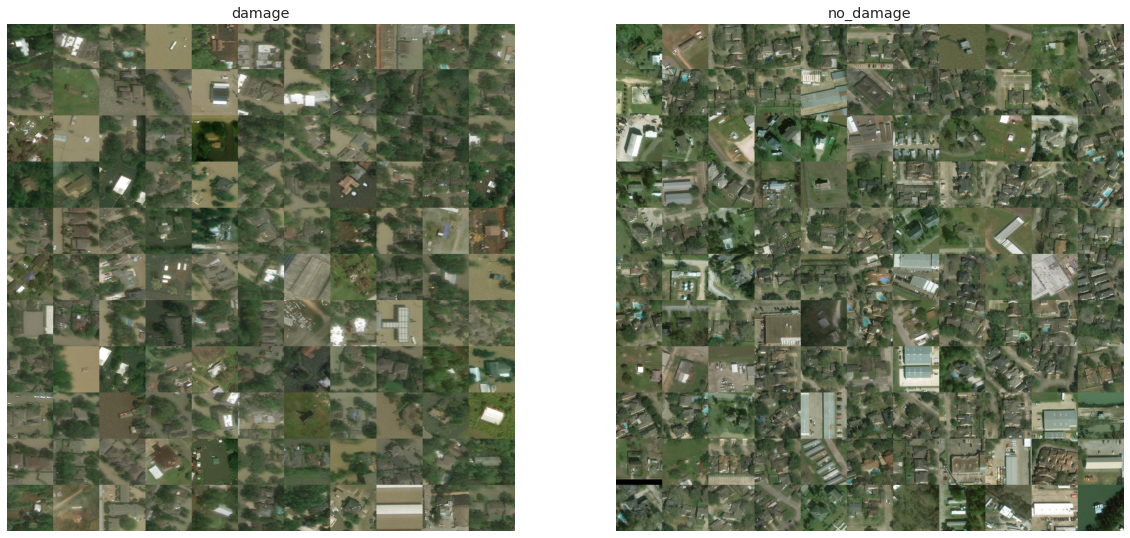

In [7]:
fig, m_axs = plt.subplots(1, 2, figsize=(20, 10))
for c_ax, (c_cat, c_rows) in zip(m_axs, image_df.groupby(['damage'])):
    img_stack = np.stack(c_rows.sample(121)['path'].map(imread), 0)
    c_ax.imshow(montage_rgb(img_stack))
    c_ax.set_title(c_cat)
    c_ax.axis('off')

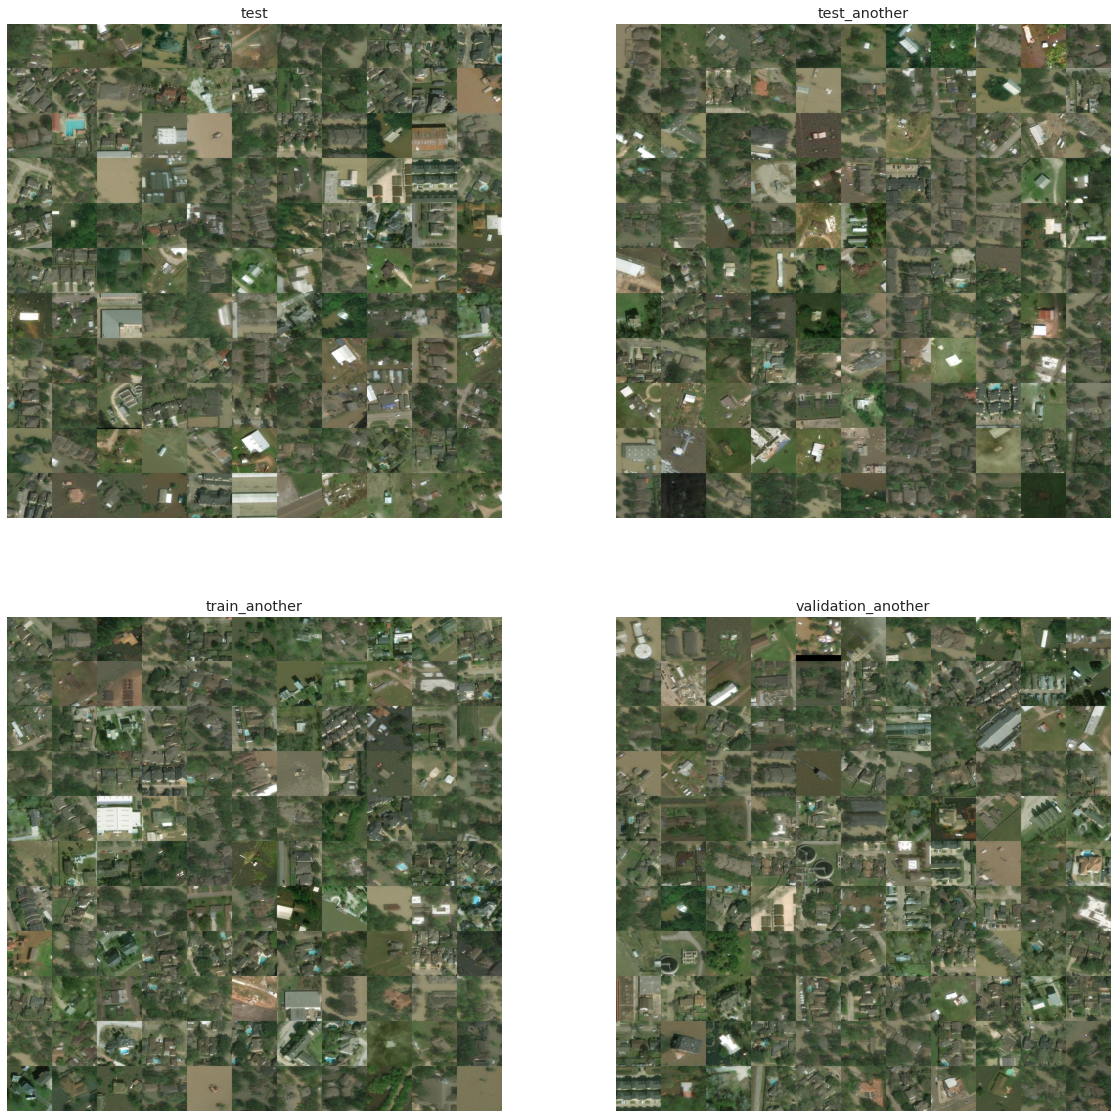

In [8]:
fig, m_axs = plt.subplots(2, 2, figsize=(20, 20))
for c_ax, (c_cat, c_rows) in zip(m_axs.flatten(), image_df.groupby(['data_split'])):
    img_stack = np.stack(c_rows.sample(121)['path'].map(imread), 0)
    c_ax.imshow(montage_rgb(img_stack))
    c_ax.set_title(c_cat)
    c_ax.axis('off')

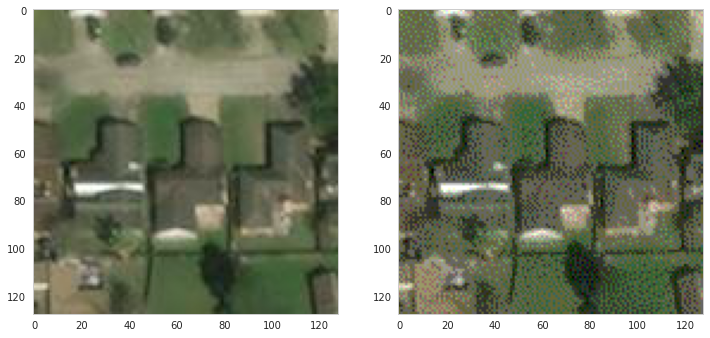

In [9]:
test_image = Image.open(image_df['path'].iloc[1010]) # normal image
# convert to 8bit color (animated GIF) and then back
web_image = test_image.convert('P', palette='WEB', dither=None)
few_color_image = web_image.convert('RGB')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(test_image)
ax2.imshow(few_color_image)

In [10]:
print('Unique colors before', len(set([tuple(rgb) for rgb in np.array(test_image).reshape((-1, 3))])))
print('Unique colors after', len(set([tuple(rgb) for rgb in np.array(few_color_image).reshape((-1, 3))])))

Unique colors before 7942
Unique colors after 43


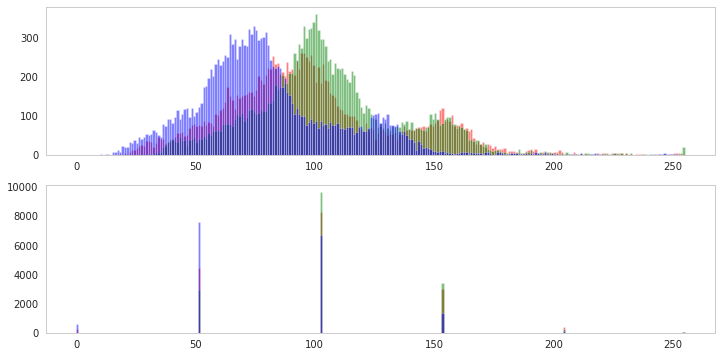

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
for c_channel, c_name in enumerate(['red', 'green', 'blue']):
    ax1.hist(np.array(test_image)[:, :, c_channel].ravel(), 
             color=c_name[0], 
             label=c_name, 
             bins=np.arange(256), 
             alpha=0.5)
    ax2.hist(np.array(few_color_image)[:, :, c_channel].ravel(), 
             color=c_name[0], 
             label=c_name, 
             bins=np.arange(256), 
             alpha=0.5)

In [12]:
idx_to_color = np.array(web_image.getpalette()).reshape((-1, 3))/255.0

Text(0, 0.5, 'Pixel Count')

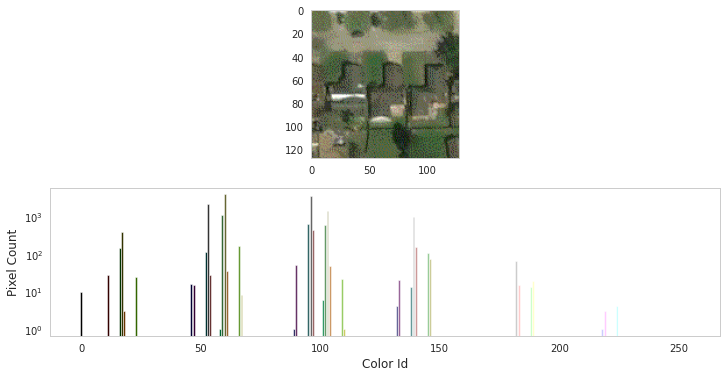

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
ax1.imshow(few_color_image)
counts, bins = np.histogram(web_image, bins=np.arange(256))
for i in range(counts.shape[0]):
    ax2.bar(bins[i], counts[i], color=idx_to_color[i])
ax2.set_yscale('log')
ax2.set_xlabel('Color Id')
ax2.set_ylabel('Pixel Count')

In [14]:
def color_count_feature(in_path):
    raw_image = Image.open(in_path) 
    web_image = raw_image.convert('P', palette='WEB', dither=None)
    counts, bins = np.histogram(np.array(web_image).ravel(), bins=np.arange(256))
    return counts*1.0/np.prod(web_image.size) # normalize output

In [15]:
%%time
image_df['color_features'] = image_df['path'].progress_map(color_count_feature)

100%|██████████| 23000/23000 [00:56<00:00, 407.77it/s]

CPU times: user 46.8 s, sys: 2.66 s, total: 49.5 s
Wall time: 56.4 s


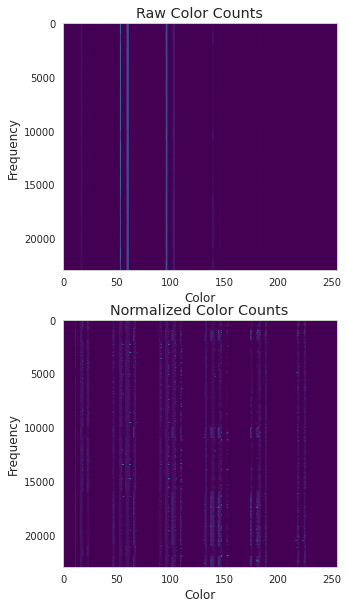

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
combined_features = np.stack(image_df['color_features'].values, 0)
ax1.imshow(combined_features)
ax1.set_title('Raw Color Counts')
ax1.set_xlabel('Color')
ax1.set_ylabel('Frequency')
ax1.set_aspect(0.01)
color_wise_average = np.tile(np.mean(combined_features, 0, keepdims=True), (combined_features.shape[0], 1)).clip(1/(128*128), 1)
ax2.imshow(combined_features/color_wise_average, vmin=0.05, vmax=20)
ax2.set_title('Normalized Color Counts')
ax2.set_xlabel('Color')
ax2.set_ylabel('Frequency')
ax2.set_aspect(0.01)

In [17]:
from sklearn.decomposition import PCA
xy_pca = PCA(n_components=2)
xy_coords = xy_pca.fit_transform(combined_features)
image_df['x'] = xy_coords[:, 0]
image_df['y'] = xy_coords[:, 1]

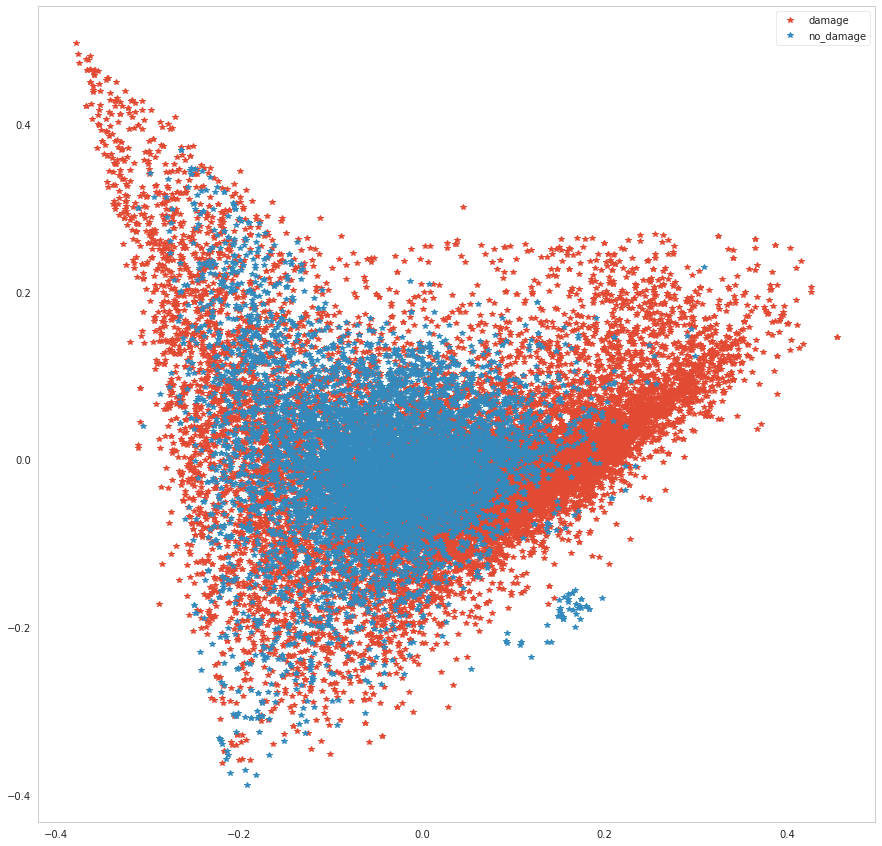

In [18]:
fig, ax1 = plt.subplots(1,1, figsize=(15, 15))
for c_group, c_row in image_df.groupby('damage'):
    ax1.plot(c_row['x'], c_row['y'], '*', label=c_group)
ax1.legend()

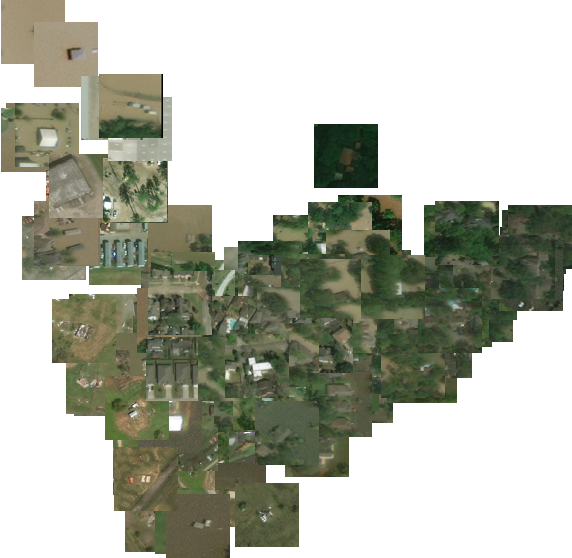

In [19]:
def show_xy_images(in_df, image_zoom=1):
    fig, ax1 = plt.subplots(1,1, figsize=(10, 10))
    artists = []
    for _, c_row in in_df.iterrows():
        c_img = Image.open(c_row['path']).resize((64, 64))
        img = OffsetImage(c_img, zoom=image_zoom)
        ab = AnnotationBbox(img, (c_row['x'], c_row['y']), xycoords='data', frameon=False)
        artists.append(ax1.add_artist(ab))
    ax1.update_datalim(in_df[['x', 'y']])
    ax1.autoscale()
    ax1.axis('off')
show_xy_images(image_df.sample(200))

In [20]:
image_df['path'] = image_df['path'].map(str) # saving pathlib objects causes problems
image_df.to_json('color_features.json')

In [21]:
image_df.sample(3)

path  ...         y
3940   /content/images_hur/test_another/damage/-95.46...  ... -0.032961
19393  /content/images_hur/train_another/no_damage/-9...  ... -0.050334
20319  /content/images_hur/train_another/no_damage/-9...  ...  0.005495

[3 rows x 9 columns]

In [45]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

from keras import models, layers
pretrained_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
feature_model = models.Sequential(name='just_features')
prep_layer = layers.Conv2D(3, 
                           kernel_size=(1, 1), 
                           weights=[np.expand_dims(np.expand_dims(np.eye(3), 0), 0), 
                                    np.array([-103.9, -116.78, -123.68])],
                           input_shape=(None, None, 3),
                          name='PreprocessingLayer')
feature_model.add(prep_layer)
feature_model.add(pretrained_model)
feature_model.add(layers.GlobalAveragePooling2D())
feature_model.save('feature_model.h5')
feature_model.summary()

94781440/94765736 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Model: "just_features"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 PreprocessingLayer (Conv2D)  (None, None, None, 3)    12        
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
Total params: 23,587,724
Trainable params: 23,534,604
Non-trainable params: 53,120
_________________________________________________________________


In [46]:
%%time
image_df['resnet_features'] = image_df['path'].progress_map(lambda x: feature_model.predict(np.expand_dims(imread(x), 0))[0])

100%|██████████| 23000/23000 [31:04<00:00, 12.34it/s]

CPU times: user 29min 23s, sys: 1min 5s, total: 30min 28s
Wall time: 31min 4s


In [47]:
image_df.to_json('resnet_features.json')

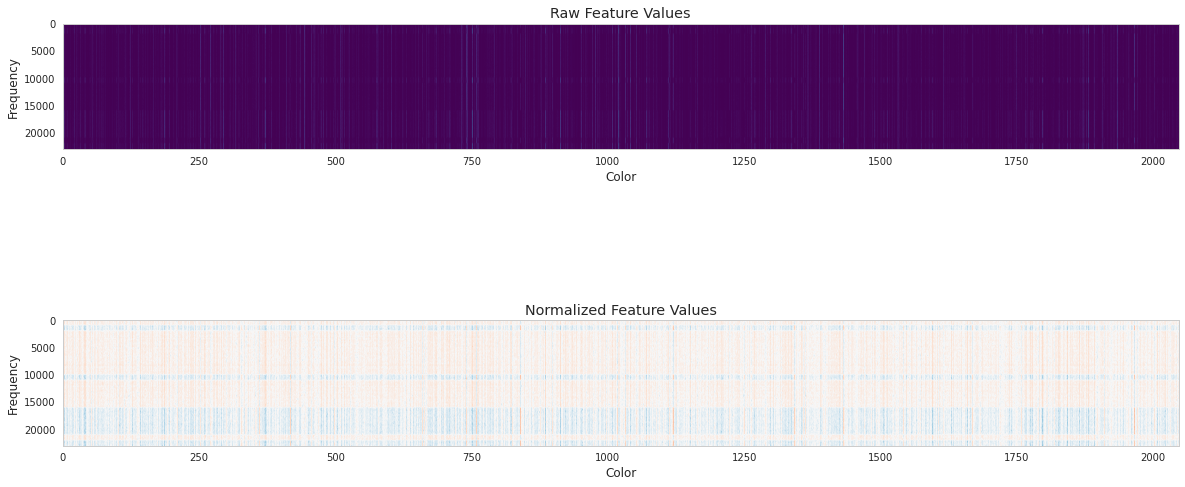

In [48]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
combined_features = np.stack(image_df['resnet_features'].values, 0)
ax1.imshow(combined_features)
ax1.set_title('Raw Feature Values')
ax1.set_xlabel('Color')
ax1.set_ylabel('Frequency')
ax1.set_aspect(0.01)
color_wise_average = np.tile(np.mean(combined_features, 0, keepdims=True), (combined_features.shape[0], 1))
color_wise_std = np.tile(np.std(combined_features, 0, keepdims=True), (combined_features.shape[0], 1)).clip(0.01, 10)
ax2.imshow((combined_features-color_wise_average)/color_wise_std, vmin=-2, vmax=2, cmap='RdBu')
ax2.set_title('Normalized Feature Values')
ax2.set_xlabel('Color')
ax2.set_ylabel('Frequency')
ax2.set_aspect(0.01)

In [49]:
from sklearn.decomposition import PCA
xy_pca = PCA(n_components=2)
xy_coords = xy_pca.fit_transform(combined_features)
image_df['x'] = xy_coords[:, 0]
image_df['y'] = xy_coords[:, 1]

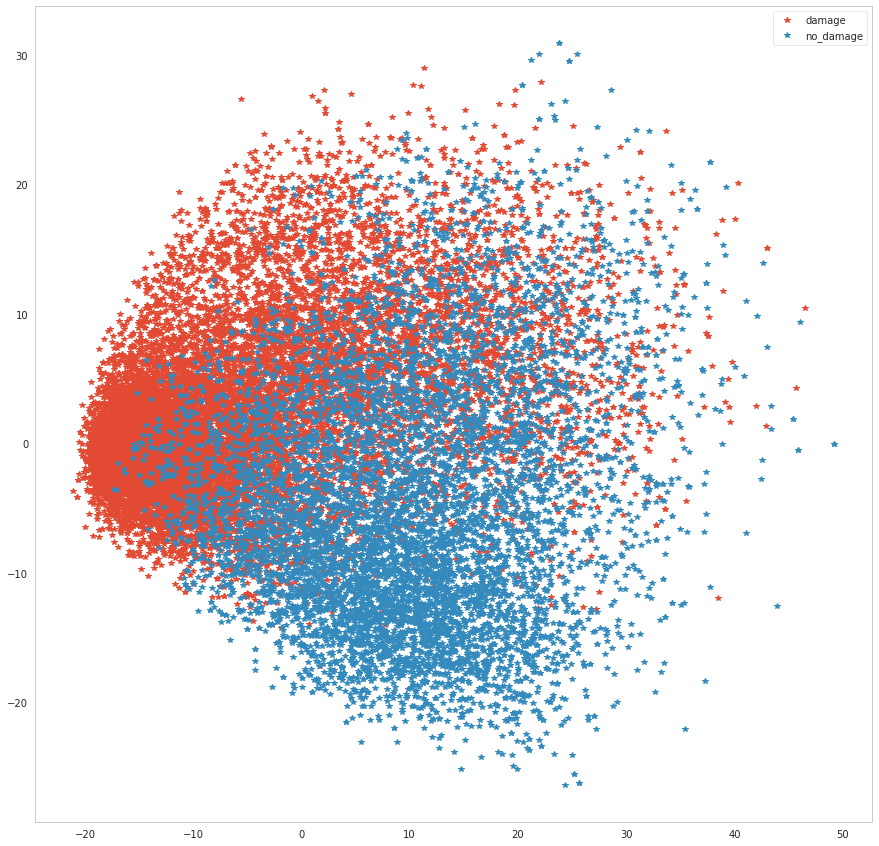

In [50]:
fig, ax1 = plt.subplots(1,1, figsize=(15, 15))
for c_group, c_row in image_df.groupby('damage'):
    ax1.plot(c_row['x'], c_row['y'], '*', label=c_group)
ax1.legend()

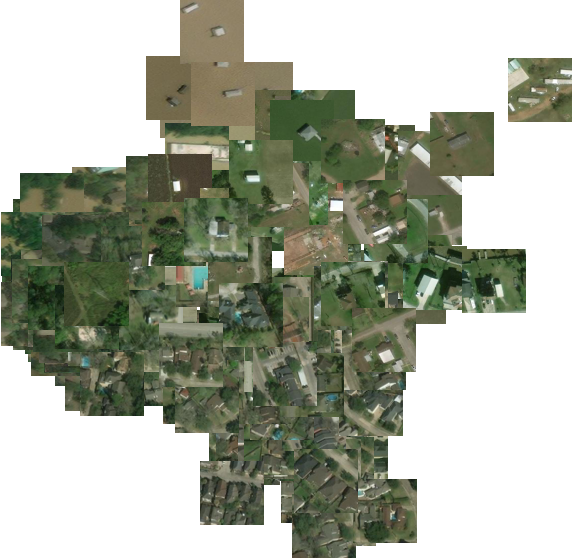

In [51]:
show_xy_images(image_df.groupby('damage').apply(lambda x: x.sample(100)))